#### A few questions to investigate

- I think we would only have excitatory synapses for the simulation. Otherwise how would we determine which synapse is ex. or in.? Can a synapse be both excitatory and inhibitory at the same time? if so or if not, is the differential equation of the membrane potential changed?
- what fractoin of all the synapses belong to ex. and in.? 
- code LIF model instead of a simple post-synaptic neuron
- run experiment on untrained model and record the spikes of the post-synaptic neuron, 
then train it and then record the spikes of the post-synaptic neuron again to see if it responds quicker as indicated 
in the paper. The input train should be the same in both cases    
- If we change the start time of the input apike train from 0ms to 10ms or 50ms, will it change the behaviour 
of the post-synaptic neuron? 
- what is the suitable run time for our experiment? how can we know if it has convereged?  

In [1]:
from brian2 import *
prefs.codegen.target = "numpy"
import copy

In [2]:

def run_experiment(input_train, num_repeat, time_between_episode):
    '''
    Note the in order to change the values of V_threshold and V_reset
    You need to change them manually in the definition of post_synapse = NeuronGroup()
    '''
    

    LIF = '''dV/dt = ( V_rest - V + g_ex * (E_ex - V) + g_in * (E_in - V) ) / tau_m : volt
             d g_ex/dt = - g_ex / tau_ex : 1
             d g_in/dt = - g_in / tau_in : 1
            '''
    post_synapse = NeuronGroup(1, model=LIF, method='euler', threshold=f'V>54*(-1)*mV', reset='V=60*(-1)*mV')

    

    synapse_eqs = '''
                g_a : 1
                dPa/dt = -Pa/tau_pre : 1
                dM/dt = -M/tau_post : 1
                '''

    S = Synapses(input_train, post_synapse,
                model=synapse_eqs,
                on_pre = '''
                    g_ex += g_a
                    g_in += g_max_in
                    Pa += A_pre
                    g_a = clip(g_a + M * g_max_ex, 0, g_max_ex)
                    ''',
                on_post = '''
                    M += A_post
                    g_a = clip(g_a + Pa * g_max_ex , 0, g_max_ex )
                    ''',
                method='exact'
                    )

    S.connect()
    S.g_a = [g_max_ex*0.2]

    # A_pre *= g_max_ex ## I think we need to do this!
    # A_post *= g_max_ex ## Actually we don't, because in the update
    ##                  ## of g_a we have g_a = g_a + M * g_max_ex
    ##                  ## which M = M + A_post 
    ##                  ## and M(t=0)=0 and g_a(t=0)=0
    ##                  ## so both the mothods in brian2 example and 
    ##                  ## in the paper are equivalent.

    pre_spike_mon = SpikeMonitor(input_train)
    post_spike_mon = SpikeMonitor(post_synapse)
    # synapse_state_monitor = StateMonitor(S, ['w'], record=arange(95,106))
    post_state_mon = StateMonitor(post_synapse, 'V', record=True)

    net = Network(input_train, post_synapse, S, pre_spike_mon, post_spike_mon, post_state_mon,) # synapse_state_monitor)
    net.run(time_between_episode * num_repeat)

    return (pre_spike_mon, post_spike_mon), S, post_state_mon, #synapse_state_monitor

Analogy :

g_ex === a variable between g_a (weight) and V (action potential)

g_a  === w (synapse weight)

g_max_ex === w_max (maximum amount of a synapse weight)

Pa  ==== trace increased by A_pre (after the increase it returns back to 0)

M   ==== trace reduced by A_post (after the reduction it returns back to 0)




In [3]:
def generate_input(N, groupsize, num_repeat, time_between_episode):
    start_scope()
    eqs = '''
    starttime : second
    rate = int(t> starttime and t<starttime + 20*ms) * 100*Hz : Hz
    '''
    pre_synapse = NeuronGroup(N, eqs, threshold='rand()<rate*dt')
    pre_synapse.starttime = repeat(rand(N//groupsize)*30, groupsize)*ms
    pre_spike_mon = SpikeMonitor(pre_synapse)

    net = Network(pre_synapse, pre_spike_mon)
    net.run(60*ms)
    del net

    fisrt_spike_time = array([pre_spike_mon.spike_trains()[i][0]/ms if len(pre_spike_mon.spike_trains()[i]) != 0 else None for i in range(N)])
    input_stimuli_monitor = pre_spike_mon

    spikes_i, spikes_t = pre_spike_mon.i, pre_spike_mon.t ## i: index and t: time (ms)
    times_added = [(i)*time_between_episode for i in range(num_repeat)]
    time_stack= [spikes_t + t for t in times_added]
    spike_times = np.concatenate(time_stack, axis= 0)* second
    spike_idx = np.tile(spikes_i, reps=num_repeat)
    input_train = SpikeGeneratorGroup(N, spike_idx, spike_times)

    return input_train, fisrt_spike_time, input_stimuli_monitor

In [82]:
def plot_experiment(file_name, display):
    description =  f'''num_repeat={num_repeat}, g_max_ex={g_max_ex}, g_max_in={g_max_in}
    taupre=taupost={tau_pre}, A_pre={A_pre:.5f}, A_post={A_post:.5f}'''

    f, ((a0, a1), (a2, a3)) = plt.subplots(2, 2, figsize=(9, 6), height_ratios=[0.7, 0.3])

    a0.plot(input_stimuli_monitor.t/ms, input_stimuli_monitor.i, '.k')
    a0.set_xlabel('Time (ms)')
    a0.set_ylabel('Neuron index')
    a0.set_title('Input stimuli')

    a1.plot(fisrt_spike_time, S.g_a/g_max_ex , '.k')
    a1.set_xlabel('First spike time [relative latency] (ms)')
    a1.set_ylabel(r'g / $g_{max}$')
    a1.set_title(r'g/$g_{max}$ ratio as a function of relative latency')
    a1.set_ylim([-0.1, 1.05])

    w_init = array([g_max_ex * 0.2] * len(S.g_a))
    a2.plot(fisrt_spike_time, w_init / g_max_ex, '.k')
    a2.set_xlabel('First spike time [relative latency] (ms)')
    a2.set_ylabel(r'g / $g_max$')
    a2.set_title(r'initial g/$g_{max}$ ratio as a function of relative latency')
    a2.set_ylim([0, 1])

    a3.plot(S.i, S.g_a / g_max_ex, '.k')
    a3.set_xlabel('Synapse index')
    a3.set_ylabel(r'g / $g_max$')
    a3.set_title(r'final g/$g_{max}$ ratio of each neuron')
    a3.set_ylim([-0.1, 1.05])

    plt.figtext(0.5, 1, description, ha='center', va='top')
    plt.tight_layout(pad=2.5)
    if file_name:
        plt.savefig(file_name)
    if not display:
        plt.close()

In [18]:
N=1000
groupsize= 100
num_repeat = 40
time_between_episode = 70*ms ## by trial 

In [19]:
input_train, fisrt_spike_time, input_stimuli_monitor = generate_input(N, groupsize, num_repeat, time_between_episode)

In [122]:
tau_m = 20*ms
V_rest = -70*mV
E_ex = 0*mV
E_in = -70*mV
# V_threshold = -54*mV
# V_reset = -60*mV

tau_ex = 5*ms
g_max_ex = 0.1 ##  0<= g_a <= g_max_ex
tau_in = 5*ms
g_max_in = 0.05 ## other than g_max_ex and g_max_in 
                ## what is the difference between an excitatory
                ## and inhibitory synapses? I can not understand!
tau_pre = tau_post = 20*ms
A_pre = 0.005 #0.005 (paper)
A_post = - A_pre * 1.05

In [123]:
input_train_temp = copy.copy(input_train)
(pre_spike_mon, post_spike_mon), S, post_state_mon = run_experiment(input_train_temp, num_repeat, time_between_episode)

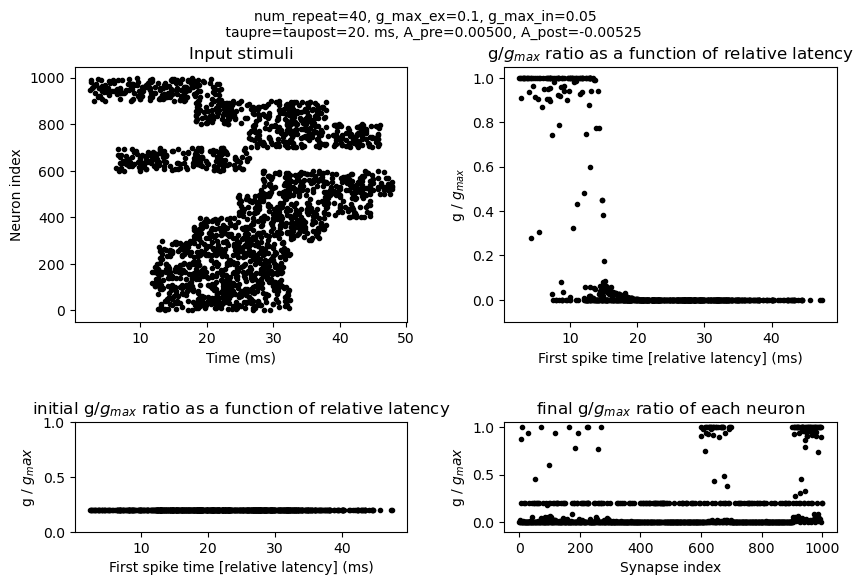

In [124]:
plot_experiment(file_name=None, display=True)

In [51]:
N=1000
groupsize= 100
num_repeat = 90
# g_max_ex = 0.50
taupre = taupost = 20*ms
# A_pre = 0.001
# A_post = - A_pre * 1.05

# num_repeats = [10, 30, 50, 70, 90, 110]
# g_max_ex_list = [0.01, 0.05, 0.1, 0.2, 0.5, 0.95]
# A_pre_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25]
g_max_ex_A_pre = [(1,0.001), (0.5, 0.0005), (1,0.01), (0.5, 0.005), (0.1, 0.001), (0.1, 0.01)]
for num_exp, (g_max_ex,A_pre) in enumerate(g_max_ex_A_pre):
    A_post = - A_pre * 1.05
    (pre_spike_mon, post_spike_mon), (first_spike_time,input_stimuli_monitor), S, post_state_mon, synapse_state_monitor = run_experiment(N, groupsize, num_repeat, g_max_ex, taupre,taupost, A_pre, A_post,time_between_episode)
    file_name = f'experiment-{num_exp+1}.png'
    plot_experiment(file_name, display=False)

## Experiments and results

### Different number of repeats

As the number of repeats increases 

### Different $g_{max}$

### Different A_pre

### Different ($g_{max}$, A_pre) pairs

In the plot bottom rigth, we can see some synapses that have value $g/g_{max}=0.2$, These synapses never fire that's why their synapse weight never changes.

## Old code

In [ ]:
## create input data
# pre_synapse = NeuronGroup(N, eqs, threshold='rand()< rate*dt')
# start_times = linspace(0,50, int(N//groupsize))
# start_times = [0, 90, 200, 250]
# pre_synapse.starttime = repeat(start_times, N/len(start_times))*ms

In [ ]:
# def run_experiment(input_train, num_repeat, g_max_ex, taupre,taupost, A_pre, A_post, time_between_episode):
#     post_synapse = NeuronGroup(1, model='v:1', threshold= 'v>10', reset='v=0')
#     S = Synapses(input_train, post_synapse,
#                 model= '''
#                     w : 1
#                     dapre/dt = -apre/ taupre : 1 (clock-driven)
#                     dapost/dt = -apost/ taupost : 1 (clock-driven)
#                     ''',
#                 on_pre='''
#                     v_post += w
#                     apre += A_pre
#                     w = clip(w+apost, 0, g_max_ex)
#                     ''',
#                     # w = clip(w+(w*apost), 0, g_max_ex)
#                 on_post='''
#                     apost += A_post
#                     w = clip(w+apre, 0, g_max_ex)
#                     ''',
#                     # w = clip(w+(w*apre), 0, g_max_ex)
#                 method='euler')

#     S.connect()
#     post_state_mon.g_ex = [0.2*g_max_ex]

#     pre_spike_mon = SpikeMonitor(input_train)
#     post_spike_mon = SpikeMonitor(post_synapse)
#     synapse_state_monitor = StateMonitor(S, ['w'], record=arange(95,106))
#     post_state_mon = StateMonitor(post_synapse, 'v', record=True)

#     net = Network(input_train, post_synapse, S, pre_spike_mon, post_spike_mon, post_state_mon, synapse_state_monitor)
#     net.run(time_between_episode * num_repeat)

#     return (pre_spike_mon, post_spike_mon), S, post_state_mon, synapse_state_monitor

In [ ]:
# def plot_experiment(file_name, display):
#     description = f'''N={N}, groupsize={groupsize}, num_repeat={num_repeat},
#     g_max_ex={g_max_ex}, taupre=taupost={taupre}, A_pre={A_pre:.3f}, A_post={A_post:.3f}'''

#     f, ((a0, a1), (a2, a3)) = plt.subplots(2, 2, figsize=(9, 6), height_ratios=[0.7, 0.3])

#     a0.plot(input_stimuli_monitor.t/ms, input_stimuli_monitor.i, '.k')
#     a0.set_xlabel('Time (ms)')
#     a0.set_ylabel('Neuron index')
#     a0.set_title('Input stimuli')

#     a1.plot(input_stimuli_time, post_state_mon.g_ex/g_max_ex , '.k')
#     a1.set_xlabel('First spike time [relative latency] (ms)')
#     a1.set_ylabel(r'g / $g_{max}$')
#     a1.set_title(r'g/$g_{max}$ ratio as a function of relative latency')

#     w_init = array([g_max_ex * 0.2] * len(post_state_mon.g_ex))
#     a2.plot(input_stimuli_time, w_init / g_max_ex, '.k')
#     a2.set_xlabel('First spike time [relative latency] (ms)')
#     a2.set_ylabel(r'g / $g_max$')
#     a2.set_title(r'initial g/$g_{max}$ ratio as a function of relative latency')

#     a3.plot(S.i, post_state_mon.g_ex / g_max_ex, '.k')
#     a3.set_xlabel('Synapse index')
#     a3.set_ylabel(r'g / $g_max$')
#     a3.set_title(r'final g/$g_{max}$ ratio of each neuron')

#     plt.figtext(0.5, 1, description, ha='center', va='top')
#     plt.tight_layout(pad=2.5)
#     if file_name:
#         plt.savefig(file_name)
#     if not display:
#         plt.close()

In [ ]:
plot(input_stimuli_monitor.t/ms, input_stimuli_monitor.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
tight_layout()
plt.show()

plot(input_stimuli_monitor.t/ms, input_stimuli_monitor.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
tight_layout()
plt.show()

plot(array(first_spike_time), post_state_mon.g_ex/g_max_ex , '.k')
xlabel('First spike time (ms)')
ylabel(r'weight / $g_{max}$')
plt.show()

w_init = array([g_max_ex * 0.2] * len(post_state_mon.g_ex))
plot(S.i, w_init / g_max_ex, '.k')
xlabel('Synapse index')
ylabel(r'Weight / $g_max$')
plt.show()

plot(S.i, post_state_mon.g_ex / g_max_ex, '.k')
xlabel('Synapse index')
ylabel(r'Weight / $g_max$')
tight_layout()
plt.show()

plot(array(first_spike_time), post_state_mon.g_ex/g_max_ex , '.k')
xlabel('First spike time (ms)')
ylabel(r'weight / $g_{max}$')
plt.show()

defining `a_pre` as 
```
dapre/dt = (0-apre)/taupre : 1
```

means that the value of `a_pre` deos not depend on time.

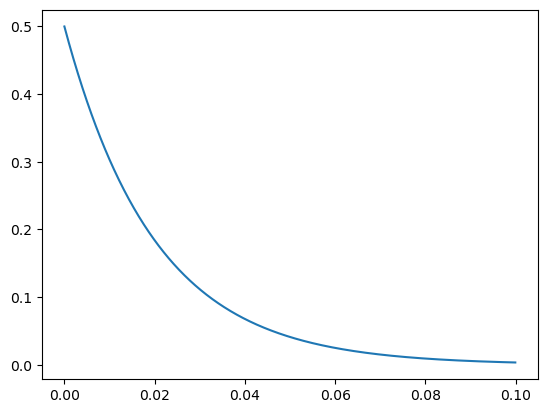

In [10]:
start_scope()
taupre = 20*ms
eqs = '''
    dapre/dt = (0-apre)/taupre : 1
'''
G = NeuronGroup(1, eqs, method='exact')
G.apre = [0.5] ## by default the initial value of any variable is 0
m = StateMonitor(G, 'apre', record=True)
run(100*ms)
plot(m.t, m.apre[0])